
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh 

____

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Uninstall existing versions
!pip uninstall -y torch torchtext

# Install specific versions
!pip install torch==1.13.0 torchtext==0.14.0


Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 81.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.4.0 requires torch>=2.1.0, but you have torch 1.13.0 which is incompatible.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 1.13.0 which is 

# 🔴 **Import Libs**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [4]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
1.13.0+cu117
0.14.0


In [5]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 1.13.0+cu117
torchtext --> 0.14.0
tqdm --> 4.66.5


# 🔴 **Utils**

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [8]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

train_data = dataset["train"]
valid_data = dataset["validation"]
test_data = dataset["test"]

print(f"Train dataset has {len(train_data)} documents.")
print(f"Validation dataset has {len(valid_data)} documents.")
print(f"Test dataset has {len(test_data)} documents.")

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Train dataset has 36718 documents.
Validation dataset has 3760 documents.
Test dataset has 4358 documents.


## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [9]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data):
    for item in data:
        yield tokenizer(item["text"])

special_tokens = ["<pad>", "<unk>", "<bos>", "<eos>"]
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=special_tokens)
vocab.set_default_index(vocab["<unk>"])

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 66061


In [10]:
vocab_path = "vocab.pth"
torch.save(vocab, vocab_path)

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [11]:
def calculate_statistics(data):
    num_documents = len(data)
    total_words = sum(len(tokenizer(doc['text'])) for doc in data)
    avg_doc_length = total_words / num_documents if num_documents > 0 else 0
    return {
        "num_documents": num_documents,
        "total_words": total_words,
        "avg_doc_length": avg_doc_length
    }

train_stats = calculate_statistics(train_data)
print(f"Number of documents: {train_stats['num_documents']}")
print(f"Total words: {train_stats['total_words']}")
print(f"Average document length: {train_stats['avg_doc_length']:.2f}")

Number of documents: 36718
Total words: 2051665
Average document length: 55.88


### 🟡 Analyze the most common and least common words in the dataset.

In [12]:
from collections import Counter

word_freq = Counter()
for doc in train_data:
    word_freq.update(tokenizer(doc['text']))

most_common_words = word_freq.most_common(10)  
least_common_words = word_freq.most_common()[:-11:-1]  

print("Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

print("\nLeast Common Words:")
for word, freq in least_common_words:
    print(f"{word}: {freq}")

Most Common Words:
the: 130770
,: 102624
.: 84291
of: 57032
and: 50736
in: 45018
to: 39522
a: 36564
=: 29570
was: 21008

Least Common Words:
pâté: 1
casseroled: 1
kv: 1
nay: 1
holler: 1
manawydan: 1
bran: 1
tamed: 1
branwen: 1
messy: 1


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

### Word Frequency Analysis

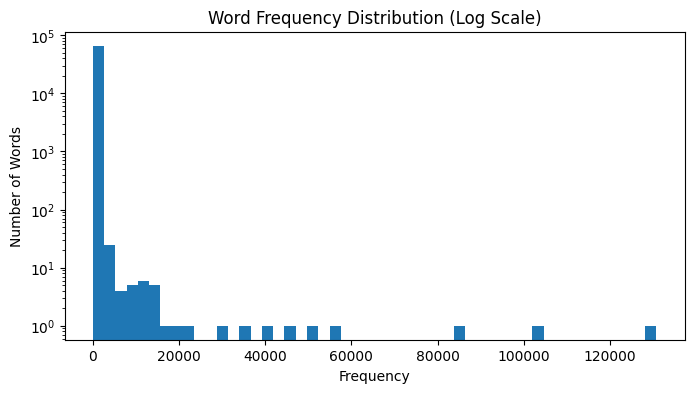

In [13]:
frequencies = [freq for _, freq in word_freq.items()]
plt.figure(figsize=(8, 4))
plt.hist(frequencies, bins=50, log=True)
plt.title("Word Frequency Distribution (Log Scale)")
plt.xlabel("Frequency")
plt.ylabel("Number of Words")
plt.show()

### N-gram Analysis

In [14]:
from collections import Counter
from itertools import islice

def yield_bigrams(data):
    for item in data:
        tokens = tokenizer(item["text"])
        bigrams = zip(tokens, islice(tokens, 1, None))  
        yield from bigrams

bigram_freq = Counter(yield_bigrams(train_data))

most_common_bigrams = bigram_freq.most_common(10)
least_common_bigrams = bigram_freq.most_common()[:-11:-1]

print("Most Common Bigrams:")
for bigram, freq in most_common_bigrams:
    print(f"{bigram}: {freq}")

print("\nLeast Common Bigrams:")
for bigram, freq in least_common_bigrams:
    print(f"{bigram}: {freq}")


Most Common Bigrams:
('of', 'the'): 17322
('=', '='): 17120
("'", 's'): 14026
('in', 'the'): 11823
(',', 'and'): 11713
('.', 'the'): 11623
(',', 'the'): 8176
('to', 'the'): 6029
('on', 'the'): 4509
('and', 'the'): 4388

Least Common Bigrams:
('acquired', 'taste'): 1
('an', 'acquired'): 1
('correctly', 'prepared'): 1
('when', 'correctly'): 1
('however', 'long'): 1
('tender', ','): 1
('until', 'tender'): 1
('stewed', 'until'): 1
('be', 'stewed'): 1
('recipe', 'said'): 1


### Sentence Length Analysis

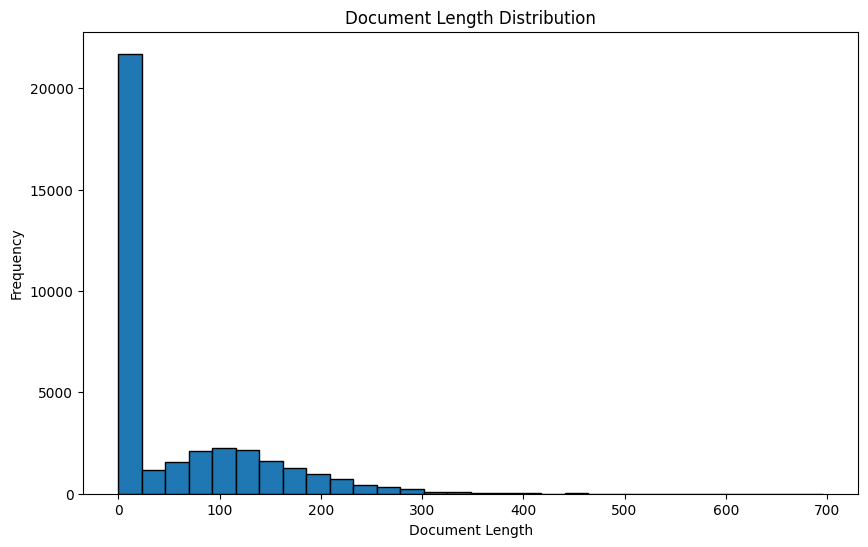

In [15]:
def tokenize_dataset(data):
    return [[vocab[token] for token in tokenizer(item["text"])] for item in data]

tokenized_train = tokenize_dataset(train_data)

doc_lengths = [len(doc) for doc in tokenized_train]
plt.figure(figsize=(10, 6))
plt.hist(doc_lengths, bins=30, edgecolor='k')
plt.title("Document Length Distribution")
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.show()


## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [16]:
def data_process(raw_text_iter, batch_size, seq_len):
    
    all_tokens = [vocab[token] for text in raw_text_iter for token in tokenizer(text["text"])]
    all_tokens = torch.tensor(all_tokens, dtype=torch.long)
    
    total_length = len(all_tokens)
    effective_length = (total_length // (batch_size * seq_len)) * (batch_size * seq_len)
    all_tokens = all_tokens[:effective_length]
    data = all_tokens.view(batch_size, -1)
    inputs = []
    targets = []
    for i in range(0, data.size(1) - seq_len, seq_len):
        input_batch = data[:, i:i + seq_len]
        target_batch = data[:, i + 1:i + seq_len + 1]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    inputs = torch.stack(inputs)  
    targets = torch.stack(targets)  
    inputs = inputs.view(-1, seq_len)  
    targets = targets.view(-1, seq_len) 
    
    return inputs, targets

In [17]:
batch_size = 16
seq_len = 64

inputs, targets = data_process(train_data, batch_size, seq_len)

print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

Input shape: torch.Size([32032, 64])
Target shape: torch.Size([32032, 64])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [18]:
class LanguageModelDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.size(0) 

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        target_sample = self.targets[idx]
        return input_sample, target_sample


In [19]:
train_dataset = LanguageModelDataset(inputs, targets)

print(f"Dataset length: {len(train_dataset)}")

Dataset length: 32032


In [20]:
inputs, targets = train_dataset[0]

print("Example input sequence:")
print(inputs)

print("Example target sequence:")
print(targets)

Example input sequence:
tensor([   12,  3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,
         3890,    24,   785, 29473,     5,  6081,     6,  3874,     7,     4,
         5054,    90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,
          885,   634,   980,     5,    26,    11,  5692,   303,    15,   578,
          235,    70,   456,    22, 14003,     8,   758,     6,  2476,    20,
            4,  1759,  5677,     6,   158,     9,   248,   359,     9,   980,
            5,    27,    26,     4])
Example target sequence:
tensor([ 3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,  3890,
           24,   785, 29473,     5,  6081,     6,  3874,     7,     4,  5054,
           90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,   885,
          634,   980,     5,    26,    11,  5692,   303,    15,   578,   235,
           70,   456,    22, 14003,     8,   758,     6,  2476,    20,     4,
         1759,  5677,     6,   158,     9,   248,   359,

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [21]:
def create_dataloaders(train_data, valid_data, test_data, batch_size, seq_len):

    train_inputs, train_targets = data_process(train_data, batch_size, seq_len)
    valid_inputs, valid_targets = data_process(valid_data, batch_size, seq_len)
    test_inputs, test_targets = data_process(test_data, batch_size, seq_len)

    train_dataset = LanguageModelDataset(train_inputs, train_targets)
    valid_dataset = LanguageModelDataset(valid_inputs, valid_targets)
    test_dataset = LanguageModelDataset(test_inputs, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader


In [22]:
batch_size = 16
seq_len = 64

train_loader, valid_loader, test_loader = create_dataloaders(train_data, valid_data, test_data, batch_size, seq_len)

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [23]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
        super(LanguageModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, src):

        embedded = self.embedding(src)  
        lstm_out, _ = self.lstm(embedded)  
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)  
        
        return logits


In [24]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_rate = 0.3

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)

batch_size = 16
seq_len = 64
input_tensor = torch.randint(0, vocab_size, (batch_size, seq_len))  

output = model(input_tensor)
print(f"Output shape: {output.shape}") 

Output shape: torch.Size([16, 64, 66061])


# 🔴 **Config**

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [26]:
import torch.optim as optim
import torch.nn.functional as F

model.to(device)

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

metric = tm.Accuracy(task="multiclass", num_classes=vocab_size).to(device)

print(f"{num_trainable_params(model):.2f}M trainable parameters.")
print(f"Optimizer: {optimizer}")
print(f"Loss function: {criterion}")

26.36M trainable parameters.
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Loss function: CrossEntropyLoss()


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [33]:
from tqdm import tqdm

def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)
      targets = targets.view(-1)    

      outputs = model(inputs)
      outputs = outputs.view(-1, vocab_size)  

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [34]:
def evaluate(model, test_loader, loss_fn, metric):
    model.eval()
    loss_eval = AverageMeter()
    metric.reset()

    with torch.inference_mode():
        tepoch = tqdm(test_loader, desc=f"Epoch {epoch}" if epoch is not None else "Evaluation", leave=True)
        for inputs, targets in tepoch:
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = targets.view(-1)

            outputs = model(inputs)
            outputs = outputs.view(-1, vocab_size)

            loss = loss_fn(outputs, targets)
            loss_eval.update(loss.item(), n=len(targets))

            metric(outputs, targets)
            
            tepoch.set_postfix(loss=loss_eval.avg)

    return loss_eval.avg, metric.compute().item()


# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [29]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  outputs = outputs.view(-1, vocab_size)
  targets = targets.view(-1)
  loss = criterion(outputs, targets)

print(loss)

tensor(11.0946, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [35]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [31]:
from torch.utils.data import Subset, DataLoader

subset_indices = list(range(1000))  
train_subset = Subset(train_dataset, subset_indices)

subset_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

In [36]:
num_epochs = 50

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
  model, train_loss, _ = train_one_epoch(model, subset_loader, criterion, optimizer, metric, epoch)
  train_losses.append(train_loss)
  valid_loss, _ = evaluate(model, valid_loader, criterion, metric)
  valid_losses.append(valid_loss)


Epoch 49: 100%|██████████| 208/208 [00:02<00:00, 84.75it/s, loss=7.12]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [48]:
num_epochs = 5

for lr in [0.001, 0.01, 0.1]:
  print(f'LR={lr}')

  model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, loss_train, metric_train = train_one_epoch(model, train_loader, criterion, optimizer, metric, epoch)

  print(f'Learning Rate = {lr}\n')

LR=0.001


Epoch 4: 100%|██████████| 2002/2002 [01:11<00:00, 28.17batch/s, loss=7.76, metric=0.0623]


Learning Rate = 0.001

LR=0.01


Epoch 4: 100%|██████████| 2002/2002 [01:11<00:00, 28.20batch/s, loss=6.91, metric=0.13] 


Learning Rate = 0.01

LR=0.1


Epoch 4: 100%|██████████| 2002/2002 [01:11<00:00, 28.12batch/s, loss=6.35, metric=0.162]

Learning Rate = 0.1



### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [50]:
num_epochs = 5

for lr in [0.01, 0.1]:
  for wd in [1e-4, 1e-3]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, criterion, optimizer, metric, epoch)

    print(f'Completed training with Learning Rate = {lr}, Weight Decay = {wd}\n')

LR=0.01, WD=0.0001


Epoch 4: 100%|██████████| 2002/2002 [01:09<00:00, 28.86batch/s, loss=7.77, metric=0.0629]


Completed training with Learning Rate = 0.01, Weight Decay = 0.0001

LR=0.01, WD=0.001


Epoch 4: 100%|██████████| 2002/2002 [01:09<00:00, 29.00batch/s, loss=7.77, metric=0.0627]


Completed training with Learning Rate = 0.01, Weight Decay = 0.001

LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 2002/2002 [01:08<00:00, 29.39batch/s, loss=6.97, metric=0.122]


Completed training with Learning Rate = 0.1, Weight Decay = 0.0001

LR=0.1, WD=0.001


Epoch 4: 100%|██████████| 2002/2002 [01:07<00:00, 29.56batch/s, loss=7.11, metric=0.11] 

Completed training with Learning Rate = 0.1, Weight Decay = 0.001



### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [51]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

In [52]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [53]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [55]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 criterion,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     criterion,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 2002/2002 [01:09<00:00, 28.98batch/s, loss=7.11, metric=0.117] 


Model Saved!
Valid: Loss = 6.685, Metric = 0.153



Epoch 1: 100%|██████████| 2002/2002 [01:11<00:00, 28.20batch/s, loss=6.61, metric=0.148]


Model Saved!
Valid: Loss = 6.519, Metric = 0.1641



Epoch 2: 100%|██████████| 2002/2002 [01:11<00:00, 28.19batch/s, loss=6.48, metric=0.155]


Model Saved!
Valid: Loss = 6.44, Metric = 0.1691



Epoch 3: 100%|██████████| 2002/2002 [01:11<00:00, 28.15batch/s, loss=6.4, metric=0.16]  


Model Saved!
Valid: Loss = 6.383, Metric = 0.1731



Epoch 4: 100%|██████████| 2002/2002 [01:11<00:00, 28.19batch/s, loss=6.35, metric=0.163]


Model Saved!
Valid: Loss = 6.353, Metric = 0.1745



Epoch 5: 100%|██████████| 2002/2002 [01:11<00:00, 28.19batch/s, loss=6.3, metric=0.166] 


Model Saved!
Valid: Loss = 6.301, Metric = 0.1787



Epoch 6: 100%|██████████| 2002/2002 [01:11<00:00, 28.19batch/s, loss=6.26, metric=0.169]


Model Saved!
Valid: Loss = 6.274, Metric = 0.1814



Epoch 7: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.21, metric=0.172]


Model Saved!
Valid: Loss = 6.227, Metric = 0.1856



Epoch 8: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.16, metric=0.176]


Model Saved!
Valid: Loss = 6.177, Metric = 0.1892



Epoch 9: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.1, metric=0.181] 


Model Saved!
Valid: Loss = 6.127, Metric = 0.1938



Epoch 10: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.05, metric=0.185]


Model Saved!
Valid: Loss = 6.082, Metric = 0.1918



Epoch 11: 100%|██████████| 2002/2002 [01:11<00:00, 28.19batch/s, loss=6, metric=0.189]   


Model Saved!
Valid: Loss = 6.039, Metric = 0.2001



Epoch 12: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=5.95, metric=0.192]


Model Saved!
Valid: Loss = 6.004, Metric = 0.2035



Epoch 13: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=5.91, metric=0.195]


Model Saved!
Valid: Loss = 5.986, Metric = 0.204



Epoch 14: 100%|██████████| 2002/2002 [01:11<00:00, 28.19batch/s, loss=5.88, metric=0.197]


Model Saved!
Valid: Loss = 5.95, Metric = 0.2073



Epoch 15: 100%|██████████| 2002/2002 [01:11<00:00, 28.17batch/s, loss=5.85, metric=0.199]


Model Saved!
Valid: Loss = 5.935, Metric = 0.2085



Epoch 16: 100%|██████████| 2002/2002 [01:11<00:00, 28.17batch/s, loss=5.83, metric=0.201]


Valid: Loss = 5.937, Metric = 0.2085



Epoch 17: 100%|██████████| 2002/2002 [01:11<00:00, 28.19batch/s, loss=5.81, metric=0.202]


Model Saved!
Valid: Loss = 5.906, Metric = 0.2105



Epoch 18: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=5.79, metric=0.204]


Model Saved!
Valid: Loss = 5.899, Metric = 0.2107



Epoch 19: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=5.77, metric=0.205]


Model Saved!
Valid: Loss = 5.888, Metric = 0.2112



## 🟠 Main Loop

🔰 Define model.

In [56]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [57]:
lr = 0.1
wd = 1e-4

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [58]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 criterion,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     criterion,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 2002/2002 [01:09<00:00, 28.93batch/s, loss=7.12, metric=0.116] 


Model Saved!
Valid: Loss = 6.687, Metric = 0.1523



Epoch 1: 100%|██████████| 2002/2002 [01:11<00:00, 28.16batch/s, loss=6.61, metric=0.147]


Model Saved!
Valid: Loss = 6.529, Metric = 0.163



Epoch 2: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.48, metric=0.155]


Model Saved!
Valid: Loss = 6.438, Metric = 0.1698



Epoch 3: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.4, metric=0.16]  


Model Saved!
Valid: Loss = 6.376, Metric = 0.174



Epoch 4: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.34, metric=0.163]


Model Saved!
Valid: Loss = 6.341, Metric = 0.1755



Epoch 5: 100%|██████████| 2002/2002 [01:11<00:00, 28.17batch/s, loss=6.29, metric=0.166]


Model Saved!
Valid: Loss = 6.3, Metric = 0.1801



Epoch 6: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.25, metric=0.169]


Model Saved!
Valid: Loss = 6.262, Metric = 0.1797



Epoch 7: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.2, metric=0.172] 


Model Saved!
Valid: Loss = 6.222, Metric = 0.1851



Epoch 8: 100%|██████████| 2002/2002 [01:11<00:00, 28.18batch/s, loss=6.15, metric=0.177]


Model Saved!
Valid: Loss = 6.168, Metric = 0.1903



Epoch 9: 100%|██████████| 2002/2002 [01:11<00:00, 28.12batch/s, loss=6.1, metric=0.181]


Model Saved!
Valid: Loss = 6.123, Metric = 0.1935



Epoch 10: 100%|██████████| 2002/2002 [01:11<00:00, 28.15batch/s, loss=6.04, metric=0.185]


Model Saved!
Valid: Loss = 6.086, Metric = 0.1971



Epoch 11: 100%|██████████| 2002/2002 [01:11<00:00, 28.15batch/s, loss=5.99, metric=0.189]


Model Saved!
Valid: Loss = 6.034, Metric = 0.1994



Epoch 12: 100%|██████████| 2002/2002 [01:11<00:00, 28.14batch/s, loss=5.95, metric=0.193]


Model Saved!
Valid: Loss = 6.005, Metric = 0.203



Epoch 13: 100%|██████████| 2002/2002 [01:11<00:00, 28.12batch/s, loss=5.91, metric=0.196]


Model Saved!
Valid: Loss = 5.977, Metric = 0.2054



Epoch 14: 100%|██████████| 2002/2002 [01:11<00:00, 28.09batch/s, loss=5.88, metric=0.198]


Model Saved!
Valid: Loss = 5.959, Metric = 0.2066



Epoch 15: 100%|██████████| 2002/2002 [01:11<00:00, 28.15batch/s, loss=5.85, metric=0.2] 


Model Saved!
Valid: Loss = 5.936, Metric = 0.2088



Epoch 16: 100%|██████████| 2002/2002 [01:11<00:00, 27.95batch/s, loss=5.82, metric=0.202]


Model Saved!
Valid: Loss = 5.936, Metric = 0.2098



Epoch 17: 100%|██████████| 2002/2002 [01:11<00:00, 27.92batch/s, loss=5.8, metric=0.203] 


Model Saved!
Valid: Loss = 5.908, Metric = 0.2102



Epoch 18: 100%|██████████| 2002/2002 [01:11<00:00, 28.12batch/s, loss=5.78, metric=0.204]


Model Saved!
Valid: Loss = 5.907, Metric = 0.2095



Epoch 19: 100%|██████████| 2002/2002 [01:11<00:00, 28.14batch/s, loss=5.76, metric=0.206]


Model Saved!
Valid: Loss = 5.89, Metric = 0.211



Epoch 20: 100%|██████████| 2002/2002 [01:11<00:00, 28.14batch/s, loss=5.76, metric=0.204]


Model Saved!
Valid: Loss = 5.878, Metric = 0.2117



Epoch 21: 100%|██████████| 2002/2002 [01:11<00:00, 28.13batch/s, loss=5.74, metric=0.207]


Model Saved!
Valid: Loss = 5.868, Metric = 0.2112



Epoch 34: 100%|██████████| 2002/2002 [01:11<00:00, 28.10batch/s, loss=5.64, metric=0.212]


Model Saved!
Valid: Loss = 5.802, Metric = 0.2143



Epoch 35: 100%|██████████| 2002/2002 [01:11<00:00, 28.07batch/s, loss=5.63, metric=0.213]


Valid: Loss = 5.803, Metric = 0.216



Epoch 36: 100%|██████████| 2002/2002 [01:11<00:00, 28.08batch/s, loss=5.62, metric=0.214]


Model Saved!
Valid: Loss = 5.792, Metric = 0.2166



Epoch 37: 100%|██████████| 2002/2002 [01:11<00:00, 28.02batch/s, loss=5.62, metric=0.214]


Model Saved!
Valid: Loss = 5.787, Metric = 0.2166



Epoch 48: 100%|██████████| 2002/2002 [01:11<00:00, 28.05batch/s, loss=5.58, metric=0.216]


Valid: Loss = 5.774, Metric = 0.2169



Epoch 49: 100%|██████████| 2002/2002 [01:11<00:00, 28.02batch/s, loss=5.57, metric=0.217]


Model Saved!
Valid: Loss = 5.764, Metric = 0.2177



## 🟠 Plot

🔰 Plot learning curves

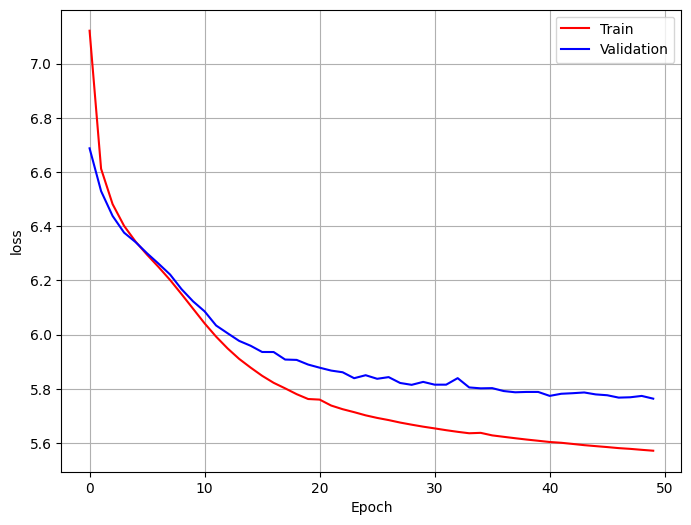

In [62]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [66]:
model_path = 'model.pt'
model = torch.load(model_path)
model.to(device)

test_loss, test_metric = evaluate(model, test_loader, criterion, metric)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metric (Accuracy): {test_metric:.4f}")

Test Loss: 5.7844
Test Metric (Accuracy): 0.2155


In [67]:
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.to(device)

model.eval()
with torch.inference_mode():
    outputs = model(inputs)
    predictions = torch.argmax(outputs, dim=-1)

print("Inputs:", inputs[0].cpu().numpy())
print("Predictions:", predictions[0].cpu().numpy())
print("Targets:", targets[0].cpu().numpy())


Inputs: [   12   636     1    12   636     1    26    33   336   106     5   394
     8  1343  1215     6    31    34    11  1805    15  4238   303    16
     4   394    96     4  1033     9   918     6    38    13   571    22
    11  4238   303     9     4   234 12671   331    22  2472 28733     5
    35    13   475     9   715    29     4   452   537  1343     6    31
    34    11  1805   303]
Predictions: [ 12  12  24  12  12  24  11 471  15   9   8   5   4   9   6   4  13  11
  40  15  88 106   9   4 106 106   7  40  14   4   6   4  13   4  22   4
  57   9   9   4 131   7   5  22   4   5   5   8  13  11   9   4   6   4
  61 106   7   6   4  13  11  57  15   9]
Targets: [  636     1    12   636     1    26    33   336   106     5   394     8
  1343  1215     6    31    34    11  1805    15  4238   303    16     4
   394    96     4  1033     9   918     6    38    13   571    22    11
  4238   303     9     4   234 12671   331    22  2472 28733     5    35
    13   475     9   715  

# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [68]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(66061, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=66061, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [69]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    tokens = tokenizer(prompt)
    token_ids = torch.tensor([vocab[token] for token in tokens], dtype=torch.long).unsqueeze(0).to(device)

    model.eval()
    generated = token_ids.clone()

    with torch.inference_mode():
        for _ in range(max_seq_len):

            outputs = model(generated)
            logits = outputs[:, -1, :]
            logits = logits / temperature

            probabilities = torch.softmax(logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            generated = torch.cat([generated, next_token_id], dim=1)

            if next_token_id.item() == vocab["<eos>"]:
                break

    generated_tokens = [vocab.lookup_token(token_id) for token_id in generated.squeeze().tolist()]
    generated_text = " ".join(generated_tokens)

    return generated_text

In [83]:
prompt = "The weather is rainy tomorrow."
max_seq_len = 64
temperature = 1

generated_text = generate(prompt, max_seq_len, temperature, model, tokenizer, vocab)
print(f"Generated Text:\n{generated_text}")

Generated Text:
the weather is rainy tomorrow . there are strikeouts or potassium 50 @-@ 60 infections are assigned to fragments of 16 years . the mitchells ' s temple was covering rap onto the land of the silver whisky , the first drains of the east early 1869 in the ganges . smut dōjin the style of 41a are generally introduced due to the food and mole treatments appears to have
